## PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

## Import libraries

In [1]:
#load the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False) 
import warnings
warnings.filterwarnings('ignore')

#pip install keras
#https://www.tensorflow.org/install/pip#windows

In [2]:
# Generating reproducible results from same code
tf.random.set_seed(14) 

In [3]:

forest=pd.read_csv('forestfires.csv')
forest.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [4]:
df = forest.copy() #Removing the dummies at this time
df.drop(df.columns[11:30],axis=1,inplace = True)

In [5]:
df.shape

(517, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [7]:
df.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'size_category'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [9]:
df.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

# Feature Analysis

In [10]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [11]:
 # The dataset is biased. Lets remove the bias.
df.size_category.value_counts() 

small    378
large    139
Name: size_category, dtype: int64

# label encoding

In [12]:
#We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


# Removing Bias in the Dataset

In [13]:
!pip install imblearn

In [14]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 373, 0: 373})


# Train | Split dataset

In [15]:
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

# Neural Network Modelling

Building the Model

In [16]:
# Create your first MLP in Keras
import keras
from keras.models import Sequential
from keras.layers import Dense

In [17]:
# create model
model = Sequential()
model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
hist = model.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=10)

Epoch 1/50
35/35 [==============================] - 1s 9ms/step - loss: 0.6926 - accuracy: 0.5129 - val_loss: 0.6864 - val_accuracy: 0.5434
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.6418 - val_loss: 0.6573 - val_accuracy: 0.7803
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.5960 - val_loss: 0.6522 - val_accuracy: 0.5434
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: 0.6005 - accuracy: 0.6447 - val_loss: 0.5435 - val_accuracy: 0.7514
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.4828 - accuracy: 0.7765 - val_loss: 0.4539 - val_accuracy: 0.7746
Epoch 6/50
35/35 [==============================] - 0s 3ms/step - loss: 0.3919 - accuracy: 0.8367 - val_loss: 0.5773 - val_accuracy: 0.7225
Epoch 7/50
35/35 [==============================] - 0s 3ms/step - loss: 0.3068 - accuracy: 0.9140 - val_loss: 0.2772 - val_accuracy: 0.9653
Epoch 8/50
35/35 [==

# Model Evaluation

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.0522 - accuracy: 0.9866


In [19]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
hist_df = pd.DataFrame(hist.history)
hist_df["epoch"]=hist.epoch
hist_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.015869,0.994269,0.043020,0.976879,45
46,0.012117,1.000000,0.038042,0.976879,46
47,0.013299,1.000000,0.040302,0.976879,47
48,0.014327,0.997135,0.038232,0.976879,48
49,0.009967,1.000000,0.062055,0.976879,49


# Visualize Training History

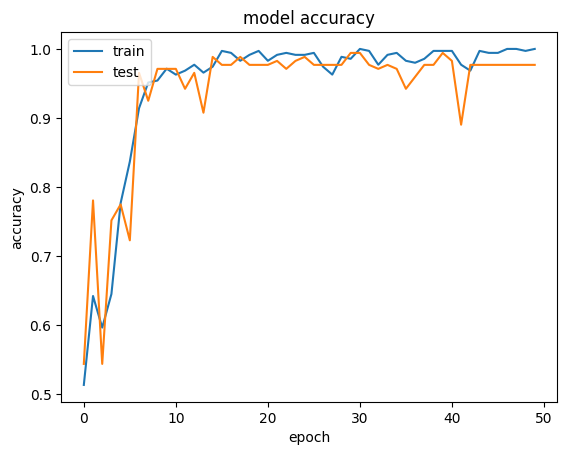

In [21]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

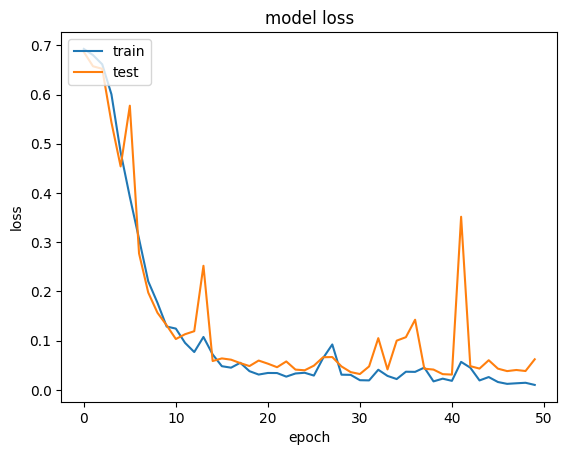

In [22]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Tuning of Hyperparameters :- Batch Size and Epochs

In [23]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

In [24]:
# create model
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [25]:
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

# Tuning of Hyperparameters:- Learning rate and Drop out rate

In [26]:
from keras.layers import Dropout

# Defining the model

def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids2 = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   2.9s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.980 total time=   2.8s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.960 total time=   2.9s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   2.8s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.987 total time=   3.0s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [27]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))
#Best score for Dropout rate = 0.2 and learning rate is 0.001

Best : 0.9879284024238586, using {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9825592756271362,0.012455545163391502 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.9798747181892395,0.017508079459528533 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.8241700291633606,0.28212095625745554 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9879284024238586,0.011550923249638786 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9852348923683166,0.016657268701971397 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.8791946232318878,0.1920448418339583 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.9852438330650329,0.013693927288217235 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9865771770477295,0.012734005434364312 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.8644384801387787,0.1855812394999361 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


# Tuning of Hyperparameters:- Activation Function and Kernel Initializer

In [28]:
# Defining the model

def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.047 total time=   4.4s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.799 total time=   3.3s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.523 total time=   3.7s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.591 total time=   3.9s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.195 total time=   3.3s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

[CV 3/5; 10/12] END activation_function=linear, init=uniform;, score=0.966 total time=   3.6s
[CV 4/5; 10/12] START activation_function=linear, init=uniform..................
[CV 4/5; 10/12] END activation_function=linear, init=uniform;, score=0.993 total time=   3.5s
[CV 5/5; 10/12] START activation_function=linear, init=uniform..................
[CV 5/5; 10/12] END activation_function=linear, init=uniform;, score=0.993 total time=   3.7s
[CV 1/5; 11/12] START activation_function=linear, init=normal...................
[CV 1/5; 11/12] END activation_function=linear, init=normal;, score=1.000 total time=   3.6s
[CV 2/5; 11/12] START activation_function=linear, init=normal...................
[CV 2/5; 11/12] END activation_function=linear, init=normal;, score=1.000 total time=   3.4s
[CV 3/5; 11/12] START activation_function=linear, init=normal...................
[CV 3/5; 11/12] END activation_function=linear, init=normal;, score=0.966 total time=   3.4s
[CV 4/5; 11/12] START activation_f

In [29]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))
#best activation function in our case would be Relu and Kernel Initializer is Uniform

Best : 0.990604019165039, using {'activation_function': 'tanh', 'init': 'uniform'}
0.43080984354019164,0.273050295313897 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.456331092864275,0.27242371650133085 with: {'activation_function': 'softmax', 'init': 'normal'}
0.4026845619082451,0.31545051994941486 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9879284024238586,0.011550923249638786 with: {'activation_function': 'relu', 'init': 'uniform'}
0.9865861177444458,0.014082256481577335 with: {'activation_function': 'relu', 'init': 'normal'}
0.20536912679672242,0.18780437310126746 with: {'activation_function': 'relu', 'init': 'zero'}
0.990604019165039,0.012447812890821868 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9879194617271423,0.013013905756522302 with: {'activation_function': 'tanh', 'init': 'normal'}
0.20536912679672242,0.18780437310126746 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9892617344856263,0.011701743295834484 with: {'activ

# Tuning of Hyperparameter :-Number of Neurons in activation layer

In [30]:
# Defining the model

def create_model4(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model4 = KerasClassifier(build_fn = create_model4,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

neuron1 = [4,8,14]
neuron2 = [4,8,12]

# Make a dictionary of the grid search parameters

param_grids4 = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid4 = GridSearchCV(estimator = model4,param_grid = param_grids4,cv = KFold(),verbose = 10)
grid_result4 = grid4.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   3.5s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.973 total time=   3.4s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.913 total time=   3.3s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.987 total time=   3.4s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.940 total time=   4.1s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [31]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

#Best results are Neuron 1 = 4 and Neuron 2 = 4

Best : 0.990604019165039, using {'neuron1': 14, 'neuron2': 12}
0.9624161005020142,0.03193389663893136 with: {'neuron1': 4, 'neuron2': 4}
0.9704787492752075,0.04085096880529567 with: {'neuron1': 4, 'neuron2': 8}
0.9798747062683105,0.020362618107311055 with: {'neuron1': 4, 'neuron2': 12}
0.9825592756271362,0.012455545163391502 with: {'neuron1': 8, 'neuron2': 4}
0.9865861177444458,0.010403062029826032 with: {'neuron1': 8, 'neuron2': 8}
0.9892706871032715,0.011704837389500391 with: {'neuron1': 8, 'neuron2': 12}
0.9825503349304199,0.012447809034425033 with: {'neuron1': 14, 'neuron2': 4}
0.9865861177444458,0.011235701188723047 with: {'neuron1': 14, 'neuron2': 8}
0.990604019165039,0.010044718062749248 with: {'neuron1': 14, 'neuron2': 12}


# Hyperparameters all at once

###### The hyperparameter optimization was carried out by taking 2 hyperparameters at once. We may have missed the best values. The performance can be further improved by finding the optimum values of hyperparameters all at once given by the code snippet below.

### This process is computationally expensive.

In [32]:
# Defining the model

def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)
#Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)


In [33]:
from sklearn.metrics import confusion_matrix,classification_report
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    print(classification_report(y_test_1,model_preds))
report_model(model_fnl)

7/7 [==============================] - 0s 5ms/step
[[114   1]
 [  1 108]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       115
           1       0.99      0.99      0.99       109

    accuracy                           0.99       224
   macro avg       0.99      0.99      0.99       224
weighted avg       0.99      0.99      0.99       224

